# Why Julia?

<div class="alert alert-block alert-info"> 
<h2>Overview</h2>
This notebook will provide an introduction into Julia, highlighting its uniqueness and features, such as:

- High-level syntax
- Performance comparable to C
- Multiple dispatch
- Dynamic typing
- Method overloading
</div>

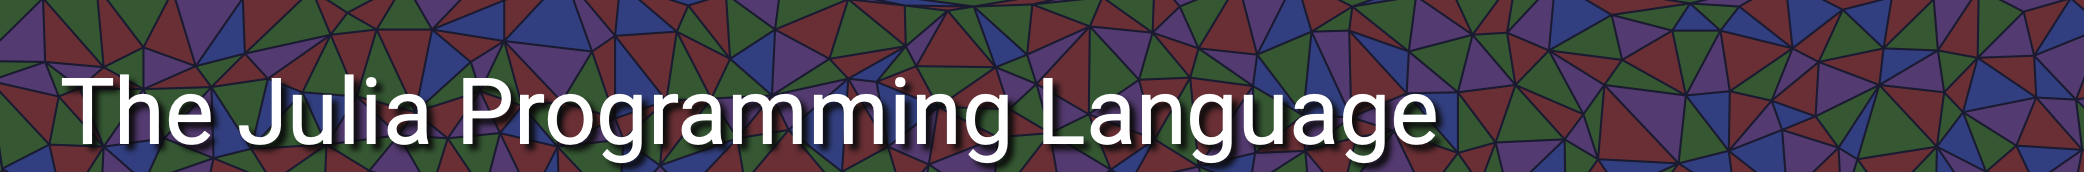

Julia is known for its speed, ease of use, and strong support for scientific computing. Some particularly notable features include:
- Capacity for high speed
- Multiple dispatch (more soon!)
- Interoperability
- Dynamic type system
- Metaprogramming functionality ("Julia all the way down")
- Built-in features for:
    - Package/environment management
    - Unit testing
    - Documentation
    - Parallelism, distributed computing, multithreading, GPU support

#### Julia's Speed and Performance

Julia compiles code just-in-time ("JIT") using LLVM, which allows it to achieve speeds similar to low-level languages like C.

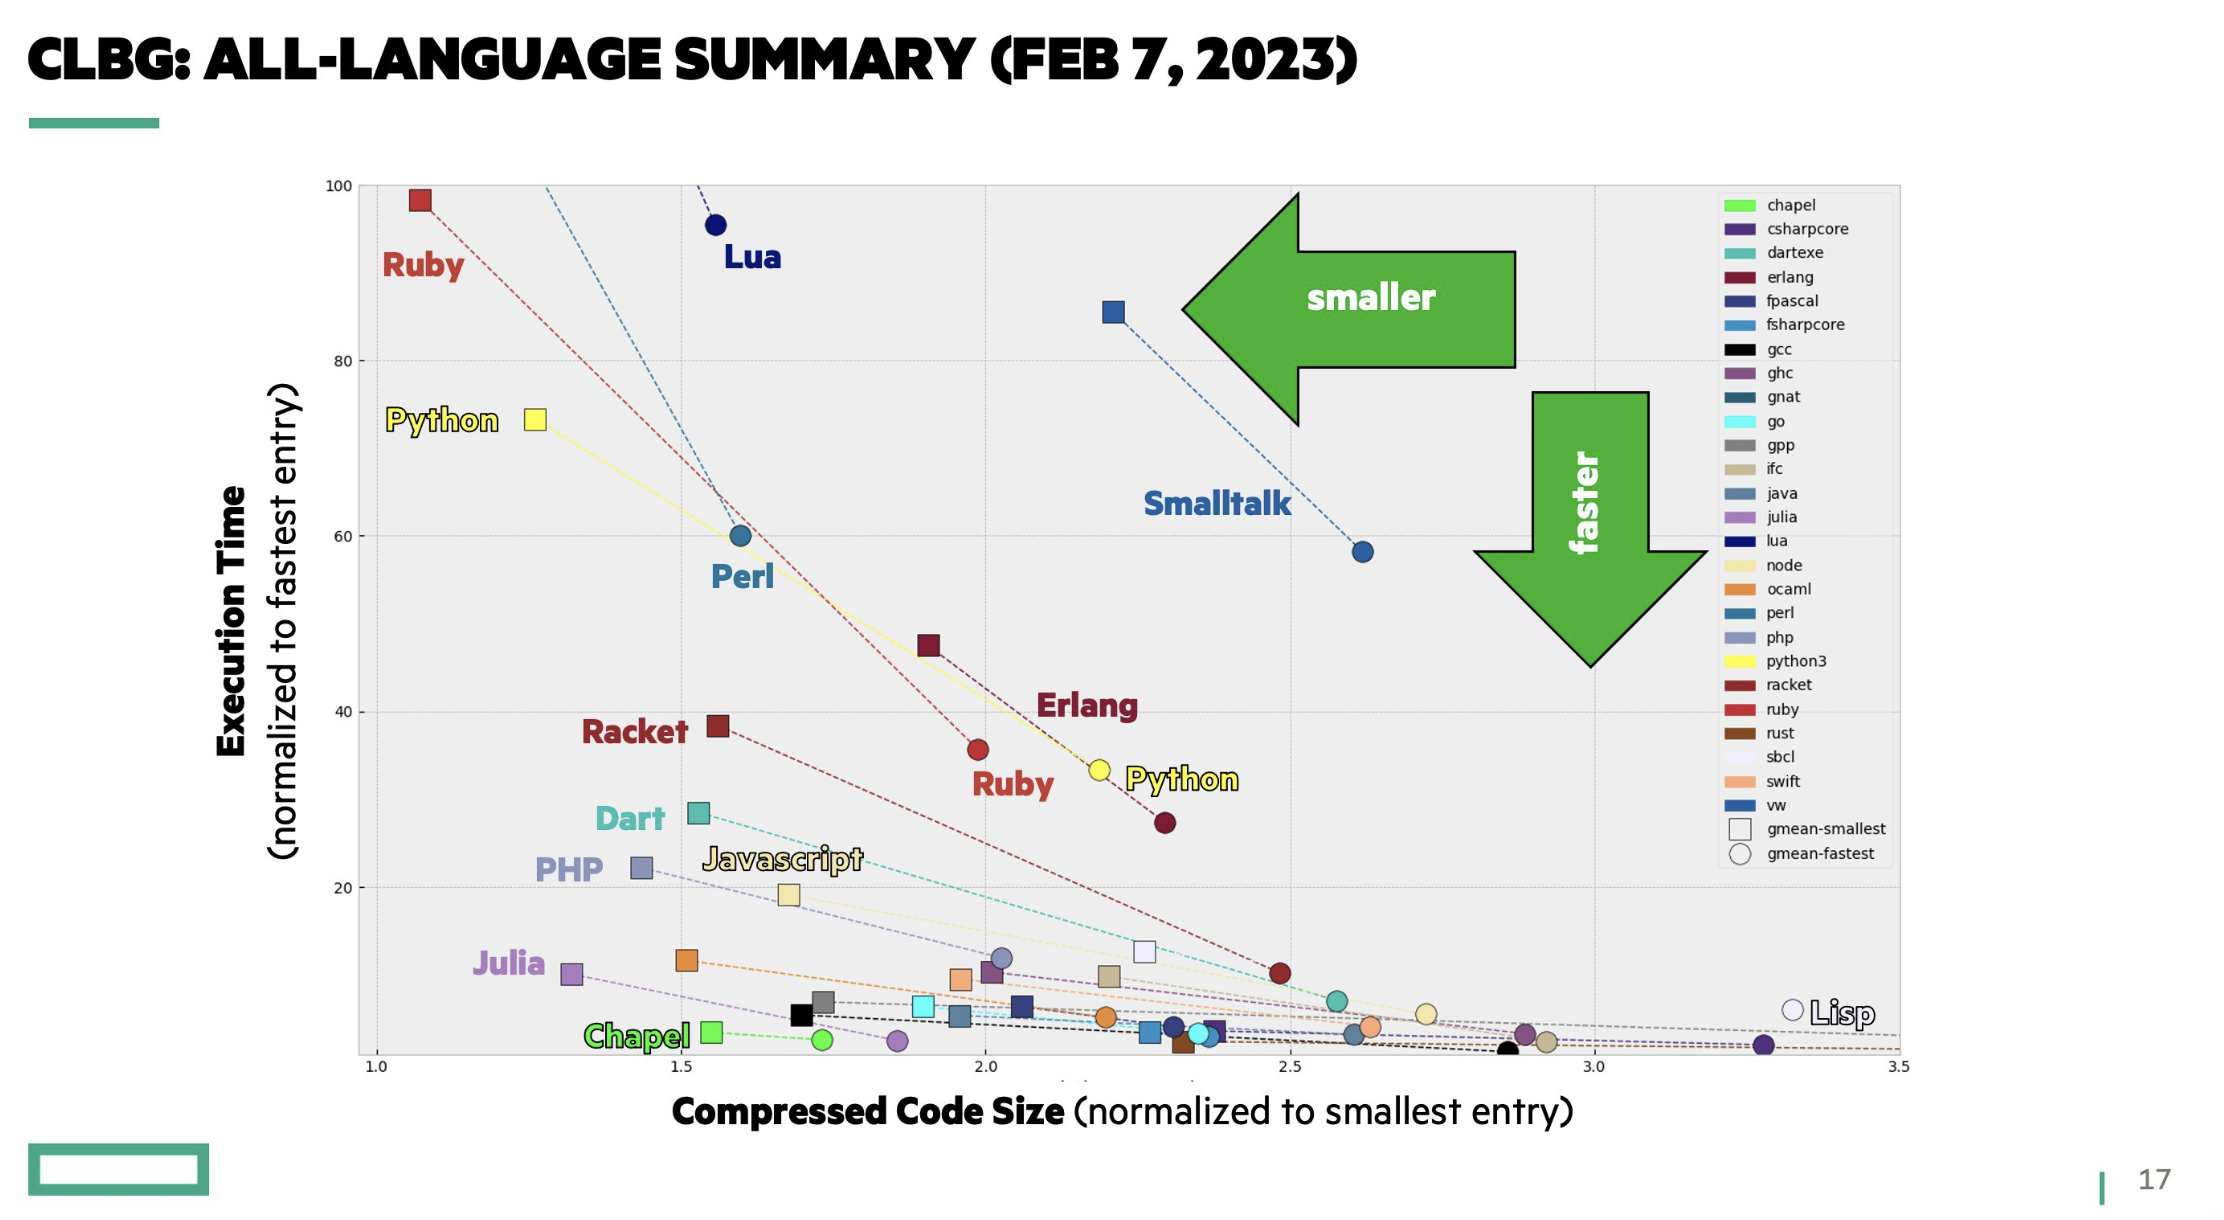

> **Reference**: [Why Julia? A manifesto](https://github.com/Datseris/whyjulia-manifesto/tree/main)

Julia has just-in-time (JIT) compilation. This means that the code is dynamically compiled during the execution of the program, also known as the program run time. In this way, the previous step of compiling the code into an executable is completely excluded from consideration.

The idea behind JIT compilation is to bring the benefits of both (static) compilation and interpretation.

> **Reference**: [The Julia Compilation Process](https://testsubjector.github.io/blog/2020/03/26/The-Julia-Compilation-Process)

Julia is (or at least can be) fast because of how it is designed. Many choices went into this design, but the core paradigm of multiple dispatch as a way to enable type stability is what many of its high-performance features rely upon, allowing Julia to be very easy for a compiler to make into efficient code, but also allowing the code to be concise/readable and "look like a scripting language". 

##### **Type-stability and Code Introspection (at a glance...)**

**Type stability**: the reasonable type to output from `*(::Int64,::Int64)` is an `Int64`:

In [ ]:
a₁ = 3
b₁ = 2
c₁ = a₁ * b₁

typeof(a₁), typeof(b₁), typeof(c₁)

In Julia, both `@code_llvm` and `@code_native` macros are used to inspect the generated code at different stages of compilation. However, they provide output at different levels of abstraction:

- `@code_llvm` provides a high-level view of the LLVM Intermediate Representation (IR) code generated by the Julia compiler.

In [ ]:
@code_llvm a₁ * b₁

- `@code_native` shows the native assembly code generated for the target machine. 

    **NOTE**: The output of `@code_native` can vary between different machines, depending on several factors related to the hardware and the Julia installation.

In [ ]:
@code_native a₁ * b₁

The reasonable type to output from `*(::Float64,::Float64)` is a `Float64`:

In [ ]:
a₂ = 3.0
b₂ = 2.0
c₂ = a₂ * b₂

typeof(a₂), typeof(b₂), typeof(c₂)

In [ ]:
@code_llvm a₂ * b₂

In [ ]:
@code_native a₂ * b₂

What happens if the code is **not type-stable**? The compiler has to generate code that can handle any type, which is slower (usually both slower to generate and to run) than code that handles only a specific type. (More on this in the optimization section!)

In [ ]:
a₃ = 3
b₃ = 2.0
c₃ = a₃ + b₃

typeof(a₃), typeof(b₃), typeof(c₃)

In [ ]:
@code_llvm a₃ * b₃

In [ ]:
@code_native a₃ * b₃

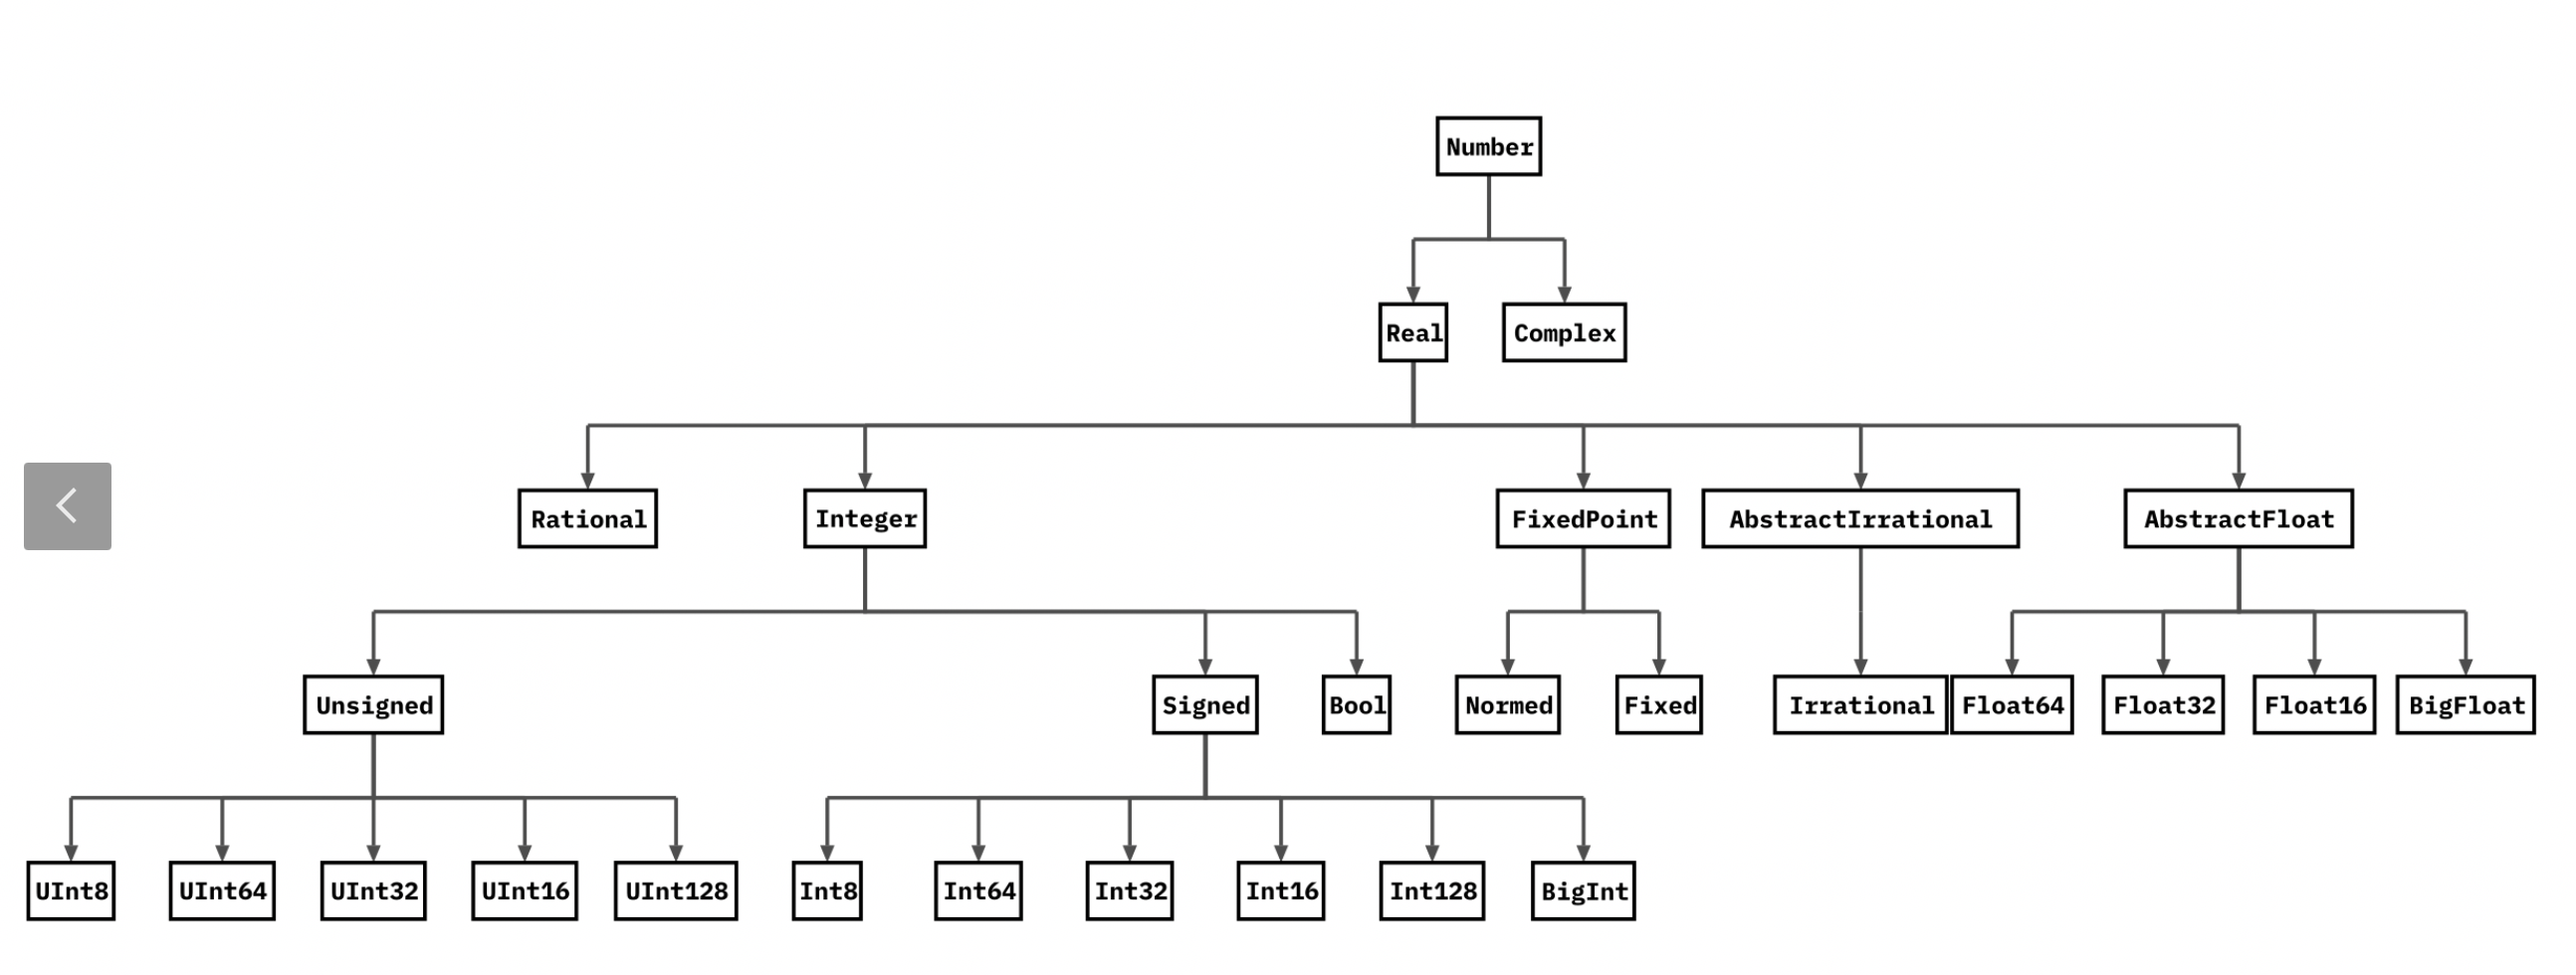

Julia's type system is dynamic, but gains some of the advantages of static type systems by making it possible to indicate that certain values are of specific types. This can be of great assistance in generating efficient code, but even more significantly, it allows method dispatch on the types of function arguments to be deeply integrated with the language. 

**Type hierarchy**: Abstract types cannot be instantiated, and serve only as nodes in the type graph (see example above for the built-in number types in Julia), thereby describing sets of related concrete types: those concrete types which are their descendants. We begin with abstract types even though they have no instantiation because they are the backbone of the type system: they form the conceptual hierarchy which makes Julia's type system more than just a collection of object implementations.

In [10]:
abstract type Number end
abstract type Real          <: Number end
abstract type AbstractFloat <: Real end
abstract type Integer       <: Real end
abstract type Signed        <: Integer end
abstract type Unsigned      <: Integer end

In [ ]:
subtypes(Number)

In [ ]:
subtypes(Real)

In [ ]:
supertype(Real)

**Composite Types**: A composite type is a collection of named fields, an instance of which can be treated as a single value. In many languages, composite types are the only kind of user-definable type, and they are by far the most commonly used user-defined type in Julia as well. (See discussion of structs in the previous notebook covering syntax)

In [ ]:
subtypes(Any)

In [ ]:
length(subtypes(Any))

All types in Julia are subtypes of `Any`, which is the top of the type hierarchy. `Any` is the default supertype of any type that is not explicitly declared to be a subtype of some other type.

In [39]:
struct Foo
    bar
    baz::Int
    qux::Float64
end

In [ ]:
Foo <: Any

In Julia, all values are objects, but functions are not bundled with the objects they operate on. This is necessary since Julia chooses which method of a function to use by multiple dispatch, meaning that the types of all of a function's arguments are considered when selecting a method, rather than just the first one. Let's dive more into the idea of multiple dispatch next...

> More information on [Julia's Type System](https://docs.julialang.org/en/v1/manual/types/)

### Multiple Dispatch in Julia

One of the most powerful features of Julia is **multiple dispatch**, where functions are chosen based on the types of all arguments, making Julia highly flexible and extensible. Multiple dispatch allows for a language to dispatch function calls onto type-stable functions. This is a key paradigm of Julia, so let's take some time to dig into it. If you have type stability inside of a function (meaning, any function call within the function is also type-stable), then the compiler can know the types of the variables at every step. Therefore, it can compile highly optimized code that runs just as fast as C or Fortran. Multiple dispatch works into this story because it means that `*` can be a type-stable function: it just means different things for different inputs. But if the compiler can know the types of `a` and `b` before calling `*`, then it knows which `*` method to use, and therefore it knows the output type of `c=a*b`.

 The dispatch system will generally choose the most specific applicable dispatch:

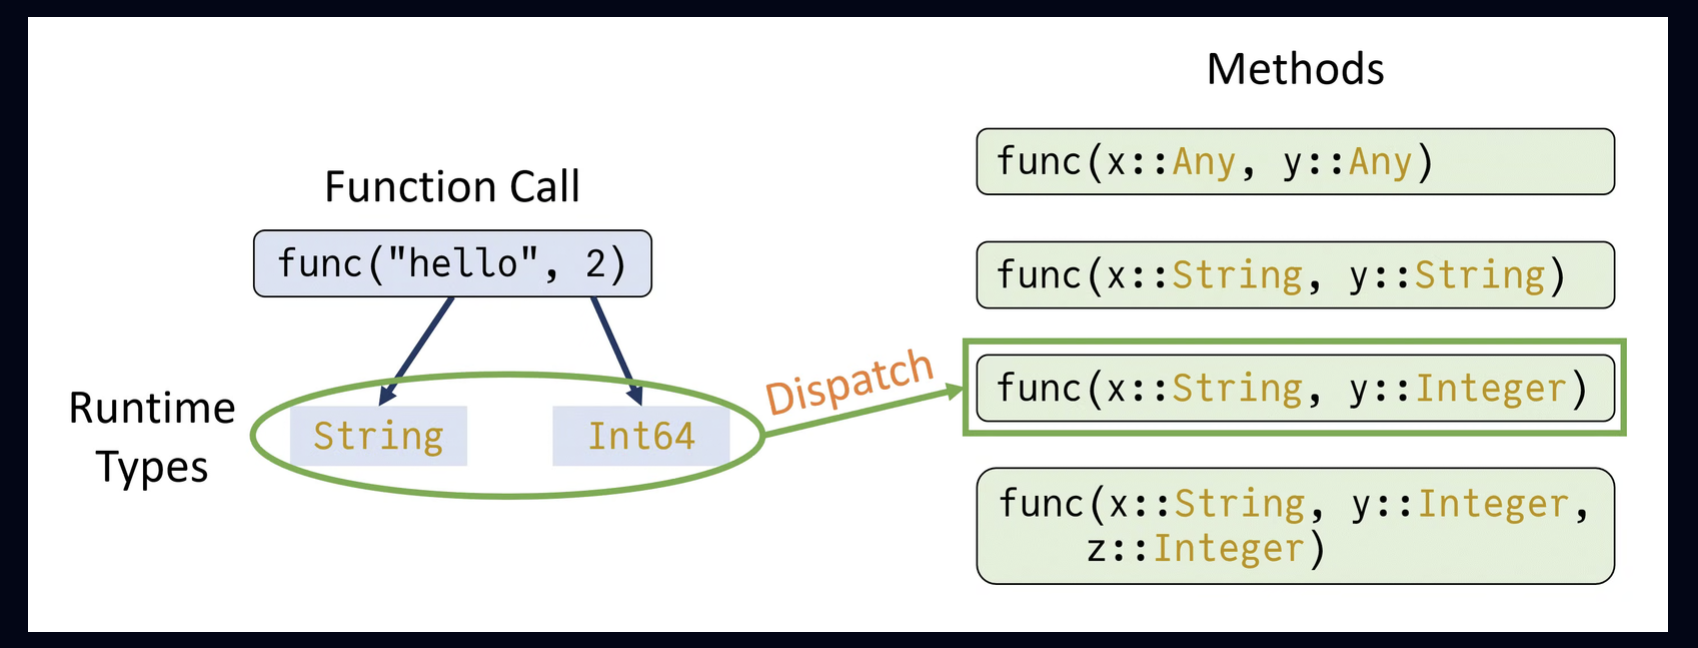

In [ ]:
x = 2 + 3
typeof(x)

Now let's use the `+` operator as an example to illustrate multiple dispatch in Julia.

In [ ]:
x = 2.0 + 3
typeof(x)

In [ ]:
length(methods(+))

#### Example of Multiple Dispatch
Let’s define a simple function that behaves differently based on the types of its arguments.

In [ ]:
# Define functions using multiple dispatch
function add(a::Int, b::Int)
    return a + b
end

Now we define a function with the same name, but to concatenate strings.

In [ ]:
function add(a::String, b::String)
    return a * b # Concatenates strings
end

In [ ]:
# Test multiple dispatch
println(add(3, 4))       # Int addition
println(add("Hello, ", "World!"))  # String concatenation

Here, Julia selects the appropriate function to run based on the type of the inputs, whether it's integers or strings.

In [ ]:
methods(add)

#### Performance Benefits of Multiple Dispatch

In Julia, multiple dispatch allows highly optimized code paths to be selected at runtime, providing both flexibility and performance.

In [ ]:
# Example of more complex dispatch based on argument types
function process_data(x::Array{Int})
    println("Processing integer array")
end

In [ ]:
function process_data(x::Array{Float64})
    println("Processing float array")
end

In [ ]:
# Test with different types
process_data([1, 2, 3])         # Dispatches to integer array method
process_data([1.1, 2.2, 3.3])   # Dispatches to float array method

Create an example of multiple dispatch (i.e. a function with at least two call signatures) below.

#### Custom Interfaces with Multiple Dispatch

We can also use multiple dispatch to define custom interfaces by implementing functions for specific types. Let's see how this works by defining an abstract type called `Shape`:

In [24]:
# Define an abstract type and a concrete subtype
abstract type Shape end

We will work now define composite types for `Circle` and `Square`:

In [25]:
struct Circle <: Shape
    radius::Float64
end

In [26]:
struct Square <: Shape
    side::Float64
end

Let's define a function that calculates the area of a shape using multiple dispatch:

In [ ]:
# Define a generic area function using dispatch
area(s::Circle) = π * s.radius^2
area(s::Square) = s.side^2

Check that the function works as we expect:

In [ ]:
circle = Circle(5.0)
square = Square(4.0)

# Test the area function
println(area(circle))  # Circle with radius 5
println(area(square))  # Square with side 4

Now here are a few examples of the power, expressiveness, and conciseness afforded by the multiple dispatch paradigm:

In [ ]:
area_squared(s::Shape) = area(s)^2
area_squared(circle)
# area_squared(square)

In [ ]:
area.([circle, square])

##### **How would this work in Python?**

In Python, we need to use `isinstance`, which checks to determine the type of an object and then call the appropriate method.

```python
import math

# Define the base class Shape
class Shape:
    pass

# Define Circle as a subclass of Shape
class Circle(Shape):
    def __init__(self, radius):
        self.radius = radius

# Define Square as a subclass of Shape
class Square(Shape):
    def __init__(self, side):
        self.side = side

# Define an area function that attempts to mimic Julia's multiple dispatch
def area(shape):
    if isinstance(shape, Circle):
        return math.pi * shape.radius ** 2
    elif isinstance(shape, Square):
        return shape.side ** 2
    else:
        raise TypeError("Unknown shape!")

# Create instances of Circle and Square
circle = Circle(5.0)
square = Square(4.0)

# Test the area function
print(f"Area of Circle with radius 5: {area(circle)}")
print(f"Area of Square with side 4: {area(square)}")

# Attempt to handle multiple shapes in a list (mimic dispatch over arrays of shapes)
shapes = [circle, square]

# This part is manual in Python unlike Julia
for shape in shapes:
    print(f"Area: {area(shape)}")
```

In Julia, this combination – the idea of a shape (and potentially, though not crucially, a corresponding abstract type) and functions like `area` that dispatch on it – is a very simple example of a powerful idea that is enabled by multiple dispatch: that of an [**interface**](https://docs.julialang.org/en/v1/manual/interfaces/). The core idea of an interface is an informal contract that says, effectively, "if you dispatch these functions on your object, then a bunch of other functionality that depends only on those functions will just work!"

Other interfaces in Julia include:
* [Indexing](https://docs.julialang.org/en/v1/manual/interfaces/#Indexing) and [iteration](https://docs.julialang.org/en/v1/manual/interfaces/#man-interface-iteration), upon which operations like sorting and slicing are built in a generalized way
* [Graphs](https://juliagraphs.org/Graphs.jl/v1.5/) (the mathematical objects with nodes and edges), which allows for functionality like graph traversal, computation of centrality measures, etc. on a wide variety of graph types
* [AtomsBase](https://juliamolsim.github.io/AtomsBase.jl/stable/), for specifying atomistic system geometries

### Extra: Advantages of Julia Dispatch

**Improved extensibility**: With Multiple Dispatch, it becomes easier to extend functionality by adding new functions or methods that handle specific argument types. This makes it straightforward to accommodate new types without modifying existing code, resulting in better code organization and modularity.

**Avoidance of complex branching and conditionals**: When dealing with different argument types, traditional approaches often involve long chains of if-else or switch-case statements to determine the appropriate action. Multiple dispatch eliminates the need for such complex branching, leading to cleaner, more readable code.

### **Caution**: Method Ambiguity

A "gotcha" that can happen is if there is not one clear "most specific" method upon which to dispatch (see example below). This situation should be avoided as it will generally lead to errors.

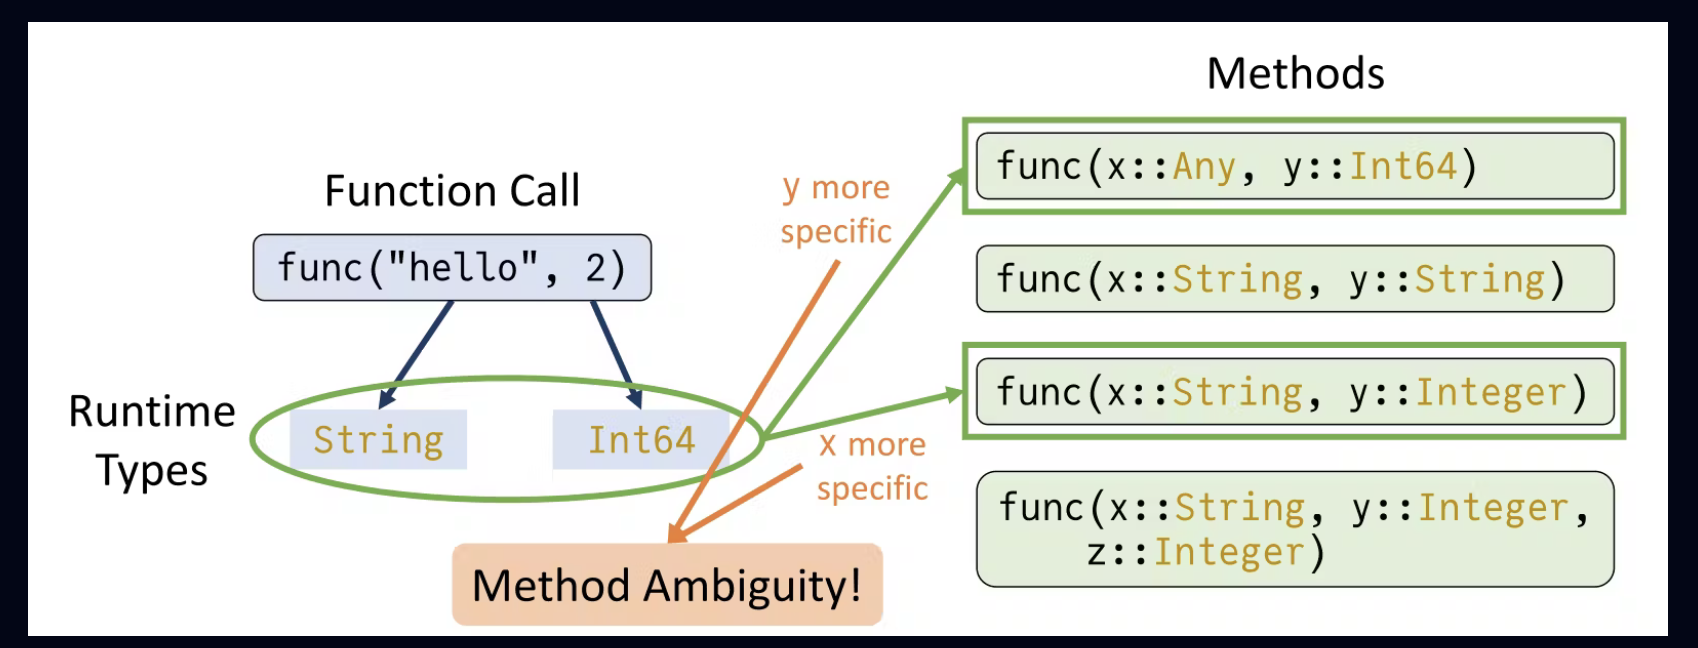

> **Reference**: [More about multiple dispatch](https://blog.glcs.io/multiple-dispatch)